<a href="https://colab.research.google.com/github/ma7moudjadallah/Colab_Code_Scraping/blob/main/CodingV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Total issues scraped: 500
Top 5 Labels:
activerecord               240
attached PR                188
With reproduction steps    181
pinned                      56
actionpack                  55
Name: count, dtype: int64
Most Popular Category (Label): activerecord


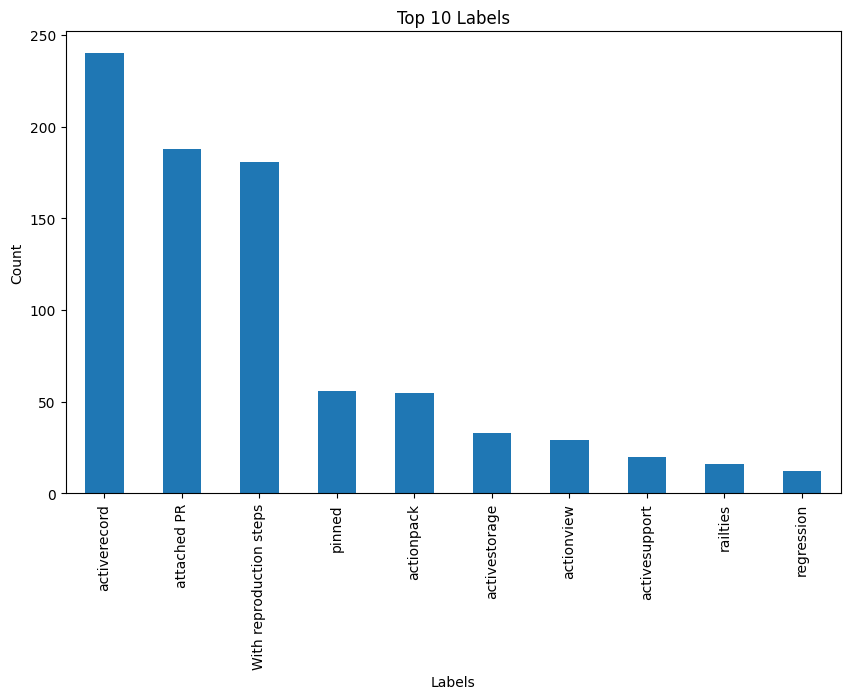

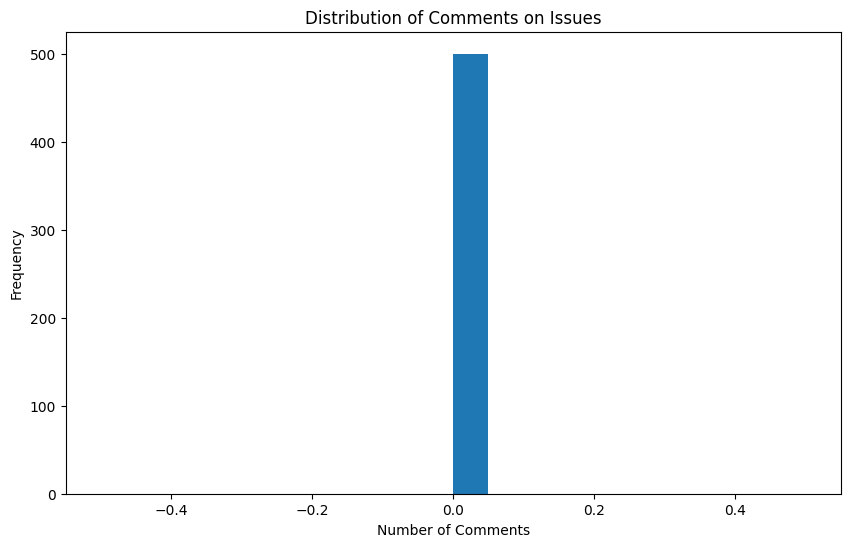

Classified Issues:
Title: Production rails server does not boot if skipping action cable in Rails 8.0.0.alpha
Predicted Label: actioncable
Confidence Score: 0.14
--------------------------------------------------
Title: rescue_from not working with subscribed method on ActionCable channel
Predicted Label: needs work
Confidence Score: 0.40
--------------------------------------------------
Title: Record foreign key does not match association's primary key after association is saved in Rails v7.2
Predicted Label: needs feedback
Confidence Score: 0.14
--------------------------------------------------
Title: PostgreSQL Apache AGE Rails (GraphDB driver questions / problems)
Predicted Label: PostgreSQL
Confidence Score: 0.24
--------------------------------------------------
Title: Content-Type parsing breaks on valid test cases
Predicted Label: needs work
Confidence Score: 0.24
--------------------------------------------------
Title: Storage folder sometimes doesn't need Kamal configurati

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline

# Function to scrape issues from the Rails GitHub repository
def scrape_issues(url, num_issues=500):
    issues = []
    page = 1
    while len(issues) < num_issues:
        response = requests.get(f"{url}?page={page}")
        soup = BeautifulSoup(response.text, 'html.parser')
        issue_elements = soup.find_all('div', class_='js-issue-row')
        for element in issue_elements:
            issue = {}
            title_element = element.find('a', class_='Link--primary')
            if title_element:
                issue['title'] = title_element.get_text().strip()
            else:
                issue['title'] = 'No title'

            issue['labels'] = [label.get_text().strip() for label in element.find_all('a', class_='IssueLabel')]

            comments_span = element.find('span', class_='Counter')
            issue['comments'] = int(comments_span.get_text().strip()) if comments_span else 0

            issues.append(issue)
        page += 1
    return issues[:num_issues]

# Function to perform exploratory data analysis
def perform_eda(issues):
    df = pd.DataFrame(issues)

    # Basic data information
    print(f"Total issues scraped: {len(df)}")

    # Top labels
    all_labels = [label for labels in df['labels'] for label in labels]
    if all_labels:
        label_counts = pd.Series(all_labels).value_counts()
        print("Top 5 Labels:")
        print(label_counts.head(5))
        popular_category = label_counts.idxmax()
        print("Most Popular Category (Label):", popular_category)

        # Plot the top labels
        label_counts.head(10).plot(kind='bar', figsize=(10, 6))
        plt.title('Top 10 Labels')
        plt.xlabel('Labels')
        plt.ylabel('Count')
        plt.show()

    # Issues by comments
    if 'comments' in df.columns:
        df['comments'] = df['comments'].astype(int)
        df['comments'].plot(kind='hist', bins=20, figsize=(10, 6))
        plt.title('Distribution of Comments on Issues')
        plt.xlabel('Number of Comments')
        plt.ylabel('Frequency')
        plt.show()

# Function to classify issues using Hugging Face's Transformers
def classify_issues(issues):
    classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", revision="c626438")
    descriptions = [issue['title'] for issue in issues]
    candidate_labels = list(set([label for issue in issues for label in issue['labels']]))
    classifications = classifier(descriptions, candidate_labels=candidate_labels)

    # Summarize classification results
    summarized_classifications = []
    for i, classification in enumerate(classifications):
        result = {
            'title': issues[i]['title'],
            'label': classification['labels'][0],
            'score': classification['scores'][0]
        }
        summarized_classifications.append(result)

    return summarized_classifications

# Main function
def main():
    url = "https://github.com/rails/rails/issues"
    issues = scrape_issues(url)
    if issues:
        perform_eda(issues)
        classified_issues = classify_issues(issues)
        print("Classified Issues:")
        for classified_issue in classified_issues[:10]:  # Display only first 10 for brevity
            print(f"Title: {classified_issue['title']}")
            print(f"Predicted Label: {classified_issue['label']}")
            print(f"Confidence Score: {classified_issue['score']:.2f}")
            print("-" * 50)

if __name__ == "__main__":
    main()